<a href="https://www.kaggle.com/code/danielfourie/ps4e3-steel-plate-defects-eda-and-xgboost?scriptVersionId=206201483" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Filter all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


<center>
    <h1>Playground Series S4E3 - Steel Plate Defect Prediction</h1>
    <img src="https://www.stainlesssteeldesignsheets.com/images/hairline-colors1.jpg">
</center>

# <u><b>Data Reading and Cleaning</b></u>

In [2]:
#import dataset
dataset = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv")

In [3]:
#Let's look at the top 5 rows
dataset.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [4]:
#set index using id
dataset = dataset.set_index('id')

In [5]:
#Let's look at the columns and their data type
dataset.dtypes

X_Minimum                  int64
X_Maximum                  int64
Y_Minimum                  int64
Y_Maximum                  int64
Pixels_Areas               int64
X_Perimeter                int64
Y_Perimeter                int64
Sum_of_Luminosity          int64
Minimum_of_Luminosity      int64
Maximum_of_Luminosity      int64
Length_of_Conveyer         int64
TypeOfSteel_A300           int64
TypeOfSteel_A400           int64
Steel_Plate_Thickness      int64
Edges_Index              float64
Empty_Index              float64
Square_Index             float64
Outside_X_Index          float64
Edges_X_Index            float64
Edges_Y_Index            float64
Outside_Global_Index     float64
LogOfAreas               float64
Log_X_Index              float64
Log_Y_Index              float64
Orientation_Index        float64
Luminosity_Index         float64
SigmoidOfAreas           float64
Pastry                     int64
Z_Scratch                  int64
K_Scatch                   int64
Stains    

**We only have two Categorical features: TypeOfSteel_A300, and TypeOfSteel_A400.<br>The rest are Numerical features, and our seven labels to predict are:<br>
Pastry, Z_Scratch, K_Scratch, Stains, Dirtiness, Bumps, and Other_Faults.**

In [6]:
#Let's see the shape of our dataset
dataset.shape

(19219, 34)

In [7]:
#Let's see how many NaN values there are
dataset.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

**We have no NaN values. This is great! We will move onto some EDA.**

# <u><b>Exploratory Data Analysis (EDA)</b></u>

In [8]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#Let's create our X (independent variable) and y (dependant variable)
X = dataset.iloc[:,:-7]
y = dataset.iloc[:,-7:]

**Let's have a look at the percentage of the number of defects per row.**

In [10]:
defect_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

for row in range(y.shape[0]):
    sum_defects = y.iloc[row, :].sum()
    defect_counts[sum_defects] += 1

for count, total in defect_counts.items():
    print(f"- Percentage of {count} {'defect' if count == 1 else 'defects'} per row across all rows = {total / y.shape[0]}")

- Percentage of 0 defects per row across all rows = 0.0425620479733597
- Percentage of 1 defect per row across all rows = 0.9563452833133878
- Percentage of 2 defects per row across all rows = 0.0010926687132525106
- Percentage of 3 defects per row across all rows = 0.0
- Percentage of 4 defects per row across all rows = 0.0
- Percentage of 5 defects per row across all rows = 0.0
- Percentage of 6 defects per row across all rows = 0.0
- Percentage of 7 defects per row across all rows = 0.0


**We see that for almost all the rows, only one defect has been picked up. This will make it harder for our model to correctly predict on unseen data, as there is such an imbalance in the training data.<br> Let's now see the percentages of how many times each defect occurs in our dataset.**

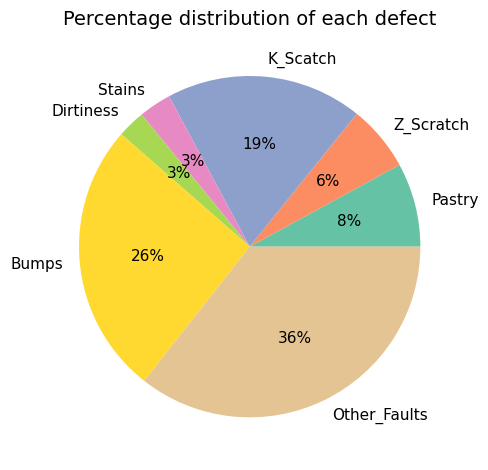

In [11]:
percs = []
for col in y.columns.tolist():
    perc = y.loc[:,col].sum()/y.shape[0]
    percs.append(perc)

plt.pie(x=percs, labels=y.columns.tolist(), colors=sns.color_palette('Set2'), autopct='%.0f%%', textprops={'fontsize': 11})
plt.title("Percentage distribution of each defect", fontsize=14)
plt.tight_layout()
plt.show()

**Let's look at the distributions of all our independent Numerical features.**

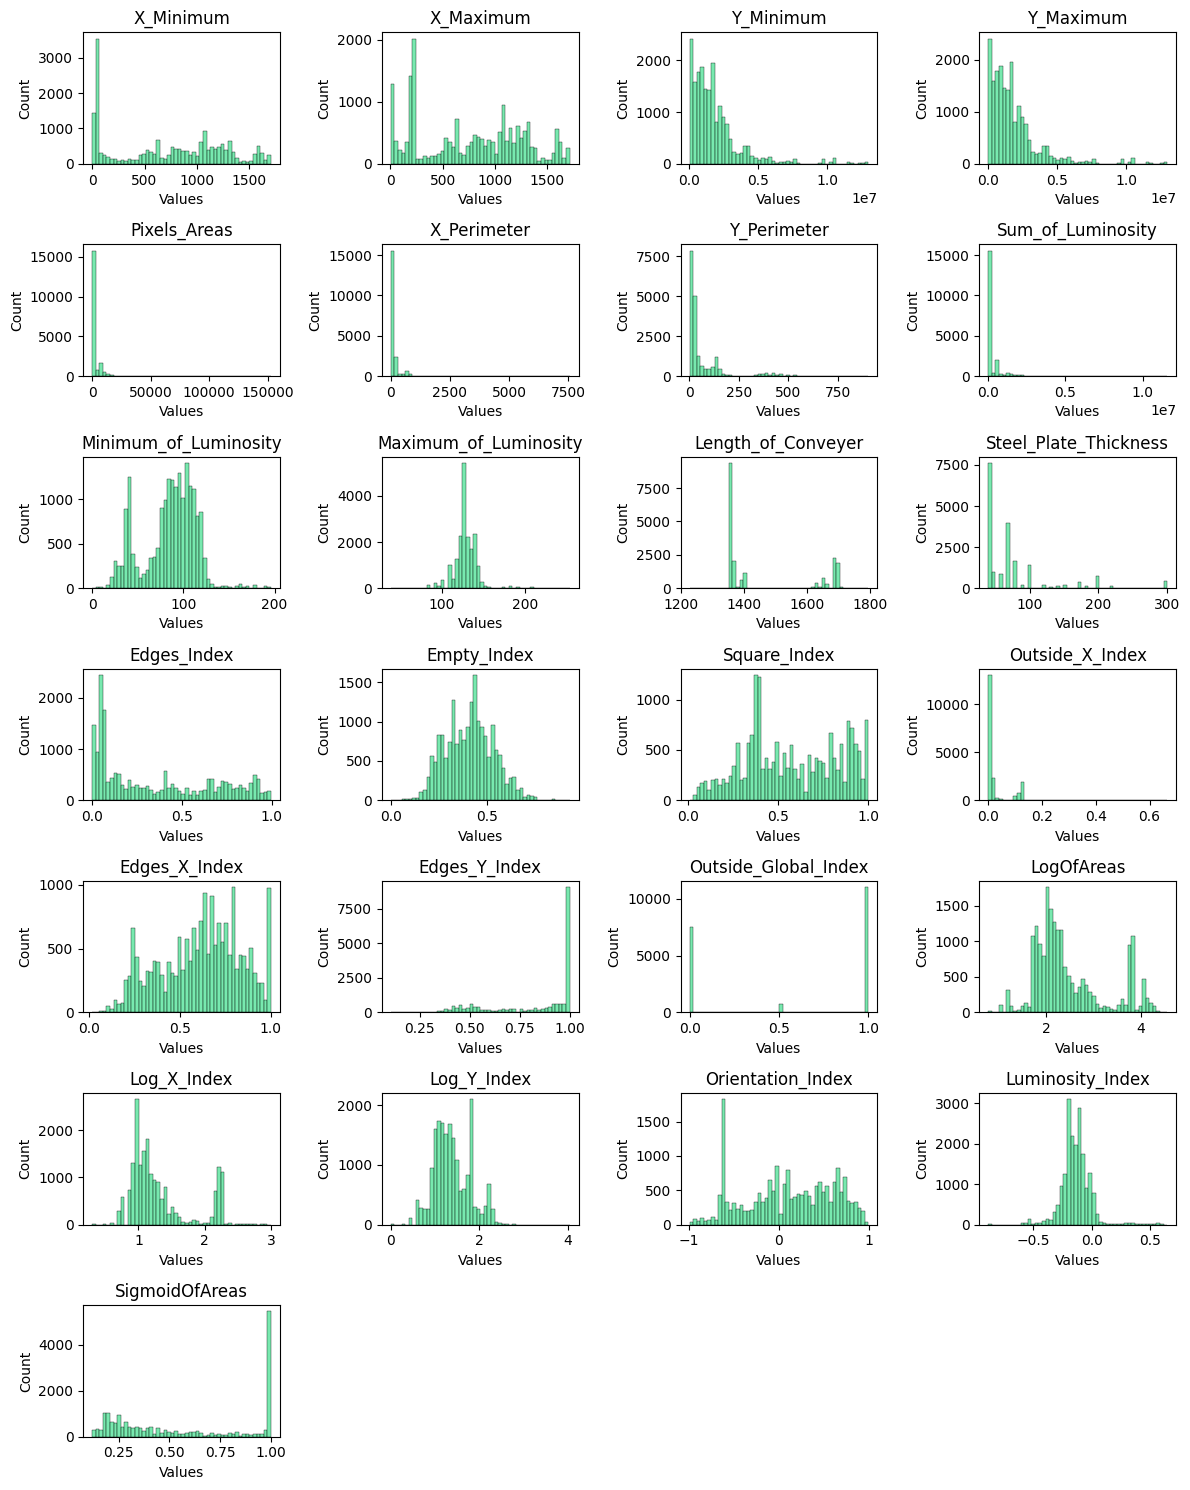

In [12]:
fig, axs = plt.subplots(7,4, figsize=(12, 15))
axs = axs.flatten() #to make indexing easier

numerical_features = X.columns.tolist()
numerical_features.remove('TypeOfSteel_A300')
numerical_features.remove('TypeOfSteel_A400')

for i, feature in enumerate(numerical_features):
    sns.histplot(data=X, x=feature, ax=axs[i], color='#4be294',bins=50)
    axs[i].set_title(feature)
    axs[i].set_xlabel('Values')
    
#Turn off the axis for the last three subplots
for ax in axs[-3:]:
    ax.axis('off')
    
plt.tight_layout()
plt.show()

**From these plots we can make the following conclusions about the features' distributions:<br>**
- Normal: Maximum_of_Luminosity, Empty_Index, Square_Index, and Luminosity_Index
- Close to normal: Minimum_of_Luminosity, and Orientation_Index
- Skewed to the right: Y_Minimum, Y_Maximum, Pixels_Areas, X_Perimeter, Y_Perimeter, and Sum_of_Luminosity
- Close to skewed to the right: Log_Y_Index
- Close to skewed to the left: Edges_X_Index
- Close to uniform: X_Minimum, X_Maximum, EdgesIndex, Edges_Y_Index, and SigmoidOfAreas

**The features not mentioned have distributions that we are unable to categorise.**

**We will later perform transformations on the features that fell into the categories: Close to normal, Skewed to the right, Close to skewed to the right, and Close to skewed to the left. We aim to transform the values in such a way that their distributions become more normal.**

**Let's look at a heatmap correlation using the Pearson Correlation Coefficient and the Spearman's Rank Correlation Coefficient between the independent features.**

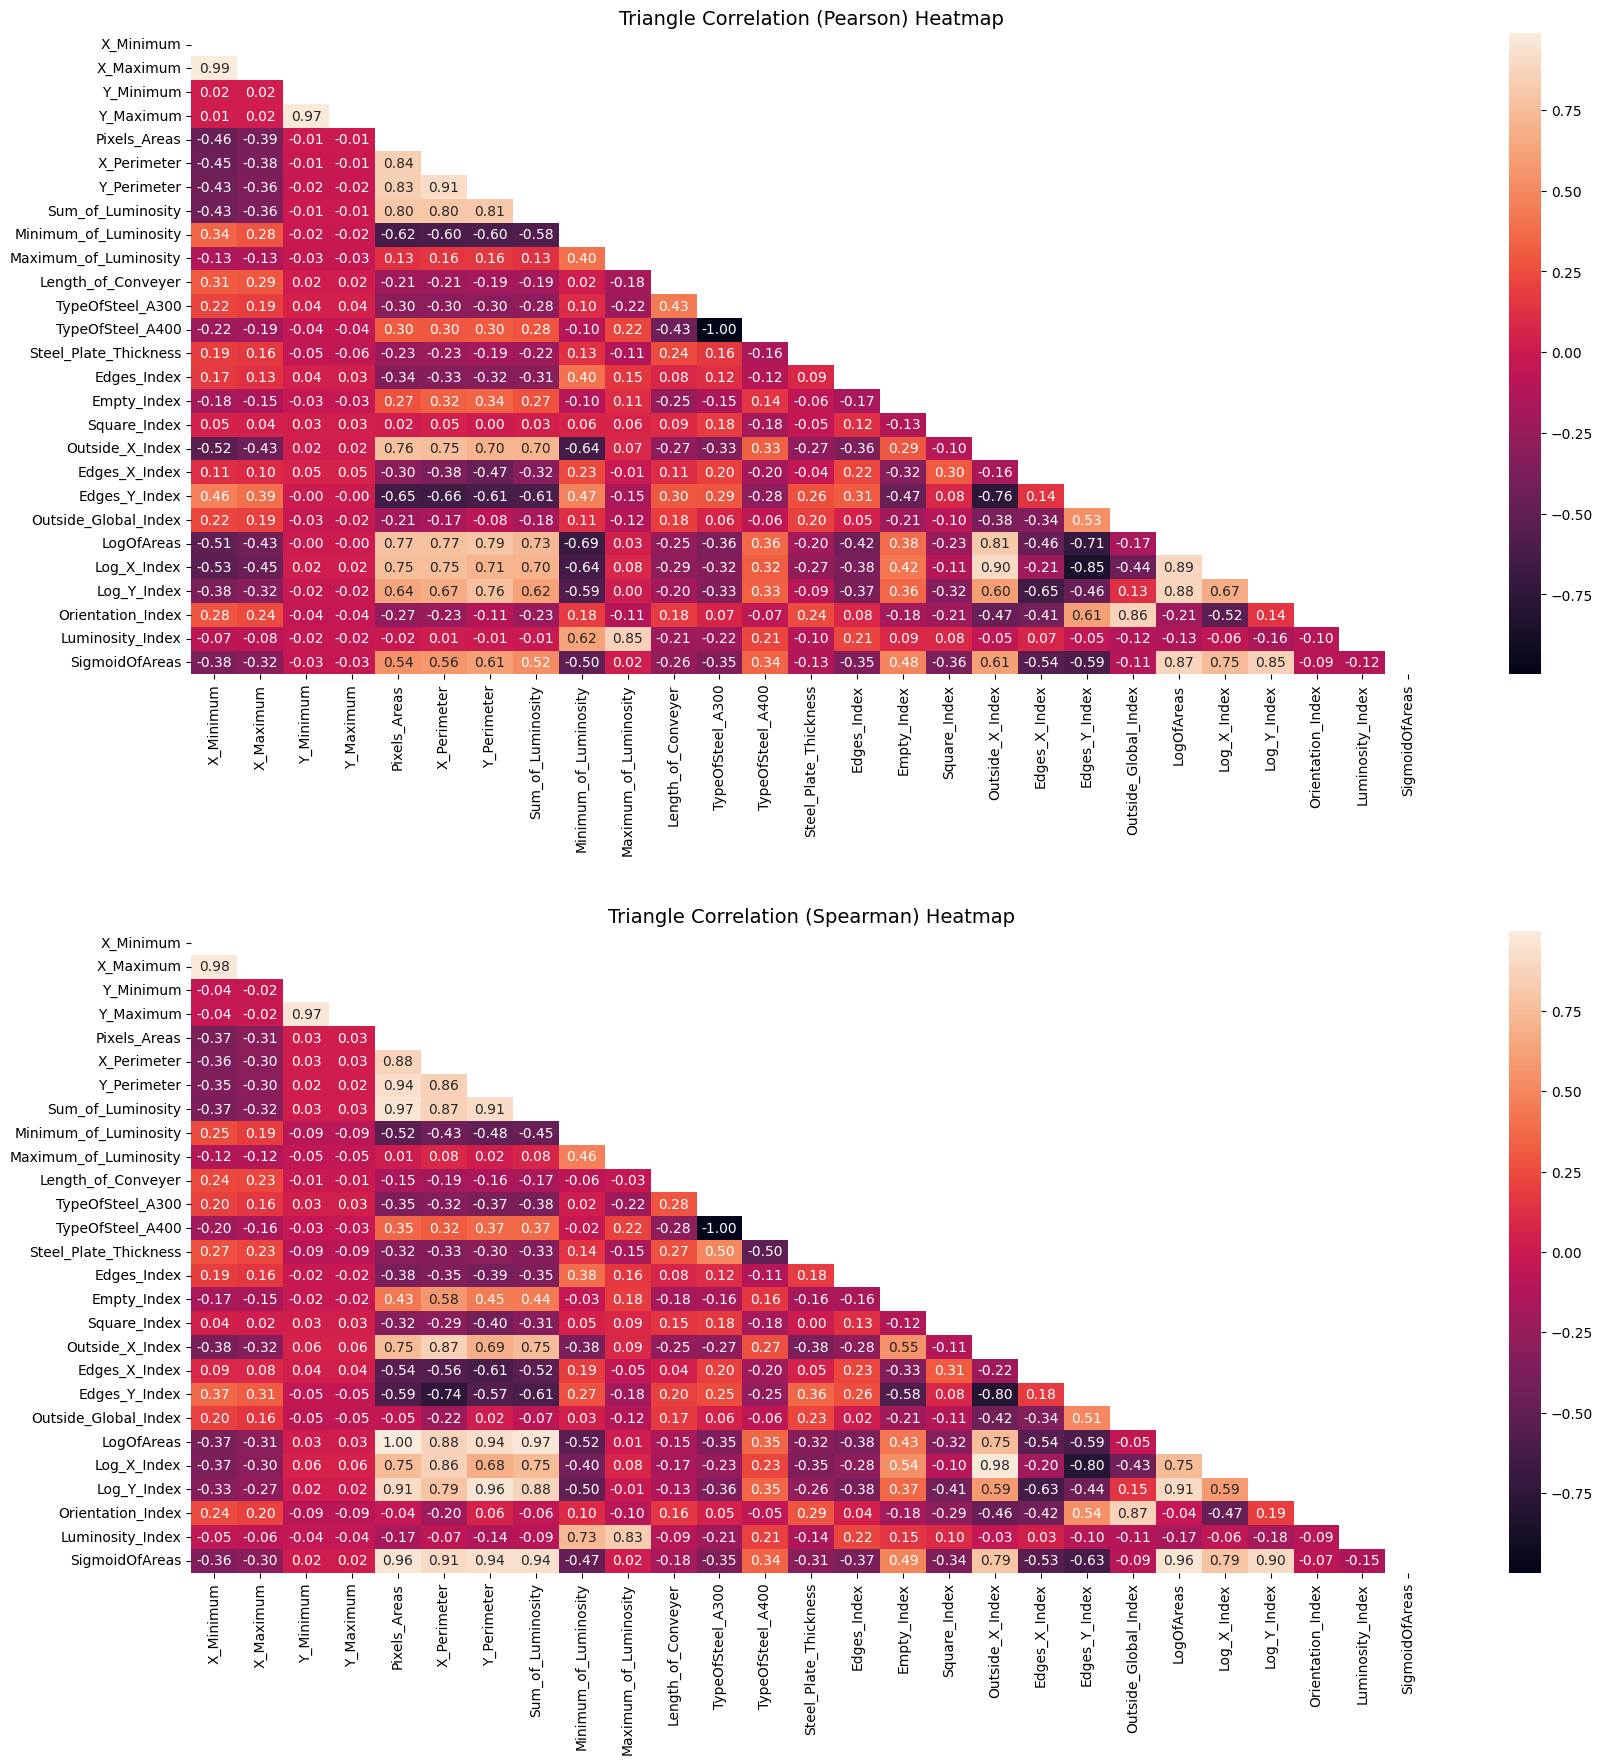

In [13]:
#specify size of heatmap
fig, axs = plt.subplots(2,1,figsize=(20,20))
#Pearson Correlation Heatmap
mask = np.triu(np.ones_like(X.corr(method='pearson'), dtype=bool))
heatmap = sns.heatmap(X.corr(method='pearson'), mask=mask, annot=True, fmt='.2f',ax=axs[0])
heatmap.set_title('Triangle Correlation (Pearson) Heatmap', fontdict={'fontsize':14})
#Spearman Correlation Heatmap
mask = np.triu(np.ones_like(X.corr(method='spearman'), dtype=bool))
heatmap = sns.heatmap(X.corr(method='spearman'), mask=mask, annot=True, fmt='.2f',ax=axs[1])
heatmap.set_title('Triangle Correlation (Spearman) Heatmap', fontdict={'fontsize':14})
plt.subplots_adjust(hspace=0.4)  # Adjust layout to prevent overlap
plt.show()

**From the heatmap above we can make the following conclusion: We will drop features X_Minimum, Y_Maximum, TypeOfSteel_A300, LogOfAreas, and Log_X_Index.**

In [14]:
#dropping highlighly linearly correlated features from heatmap (Pearson and Spearman)
features_to_drop = ['X_Minimum','Y_Maximum','TypeOfSteel_A300','LogOfAreas','Log_X_Index']
X.drop(features_to_drop,axis=1,inplace=True)
numerical_features = [feature for feature in numerical_features if feature not in features_to_drop]

# <u><b>Feature Engineering and Data Preparation</b></u>

**We will now perform transformations on the skewed to right features. Note: I have already performed multiple transformations on each of these features and have chosen the optimal ones which are used below. The same goes for other feature transformations further in this notebook.**

In [15]:
#Transformations on skewed_to_the_right features
from scipy.stats import boxcox, yeojohnson
#YeoJohnson transformation on Y_Minimum
X['Y_Minimum'], yj_lambda_val_Y_Minimum = yeojohnson(X['Y_Minimum'])
#BoxCox transformation on Pixels_Areas, X_Perimeter, Y_Perimeter, and Sum_of_Luminosity
X['Pixels_Areas'], boxcox_lambda_val_Pixels_Areas = boxcox(X['Pixels_Areas'])
X['X_Perimeter'], boxcox_lambda_val_X_Perimeter = boxcox(X['X_Perimeter'])
X['Y_Perimeter'], boxcox_lambda_val_Y_Perimeter = boxcox(X['Y_Perimeter'])
X['Sum_of_Luminosity'], boxcox_lambda_val_Sum_of_Luminosity = boxcox(X['Sum_of_Luminosity'])

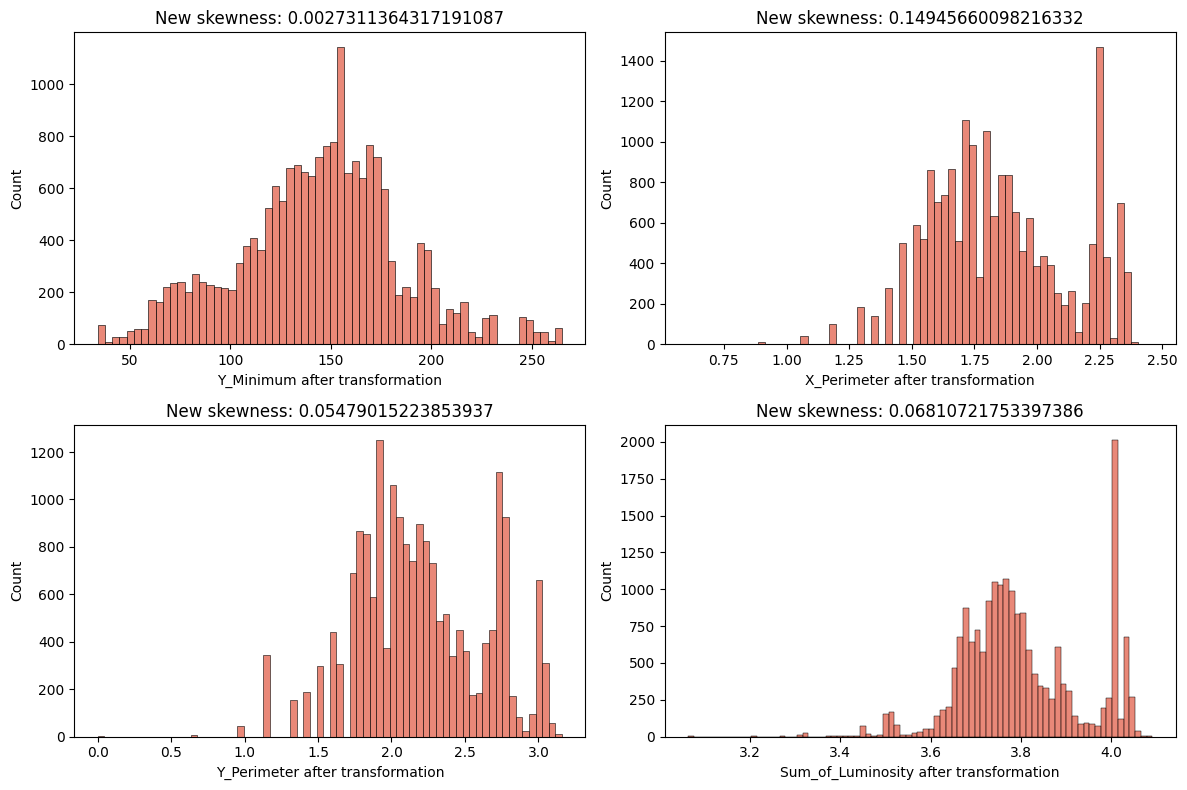

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.style.use('seaborn-v0_8-whitegrid')
#Flatten the 2D array of axes for easy indexing
axs = axs.flatten()
skewed_to_the_right = ['Y_Minimum', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity']

for i, feature in enumerate(skewed_to_the_right):
    sns.histplot(data=X,x=feature,ax=axs[i],color='#e2604b')
    axs[i].set_xlabel(f'{feature} after transformation')
    axs[i].set_title(f'New skewness: {X[feature].skew()}')

plt.tight_layout()
plt.show()

**We notice our distributions now look much more normal than before.**

**We will now perform an inverse log transformation on the close to skewed to the left feature Edges_X_Index, and compare the histograms of the feature before and after the transformation.**

In [17]:
#Transformations on Edges_X_Index
X['exp(Edges_X_Index)'] = np.exp(X['Edges_X_Index'])

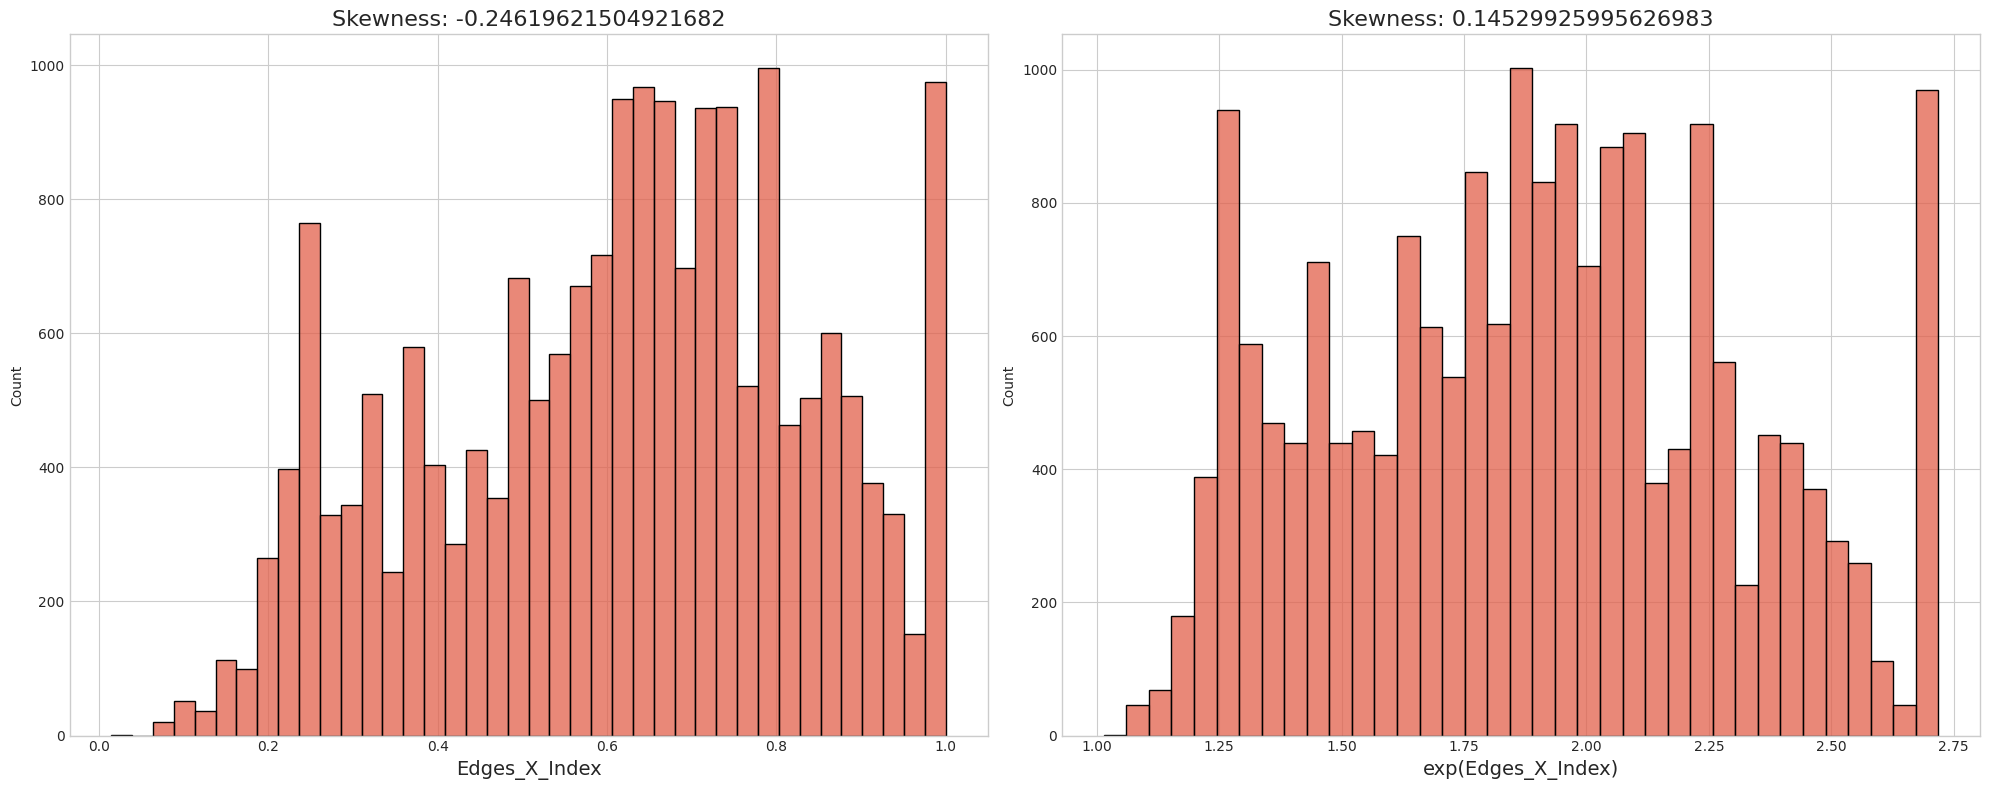

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.style.use('seaborn-v0_8-whitegrid')
#Flatten the 2D array of axes for easy indexing
axs = axs.flatten()
features = ['Edges_X_Index','exp(Edges_X_Index)' ]

for i, feature in enumerate(features):
    sns.histplot(data=X,x=feature,ax=axs[i],color='#e2604b')
    axs[i].set_xlabel(f'{feature}',fontsize=14)
    axs[i].set_title(f'Skewness: {X[feature].skew()}',fontsize=16)

plt.tight_layout()
plt.show()

**We can see that the distribution has become more normal (Guassian-like). We will now replace Edges_X_Index with the transformed version.**

In [19]:
X['Edges_X_Index'] = X['exp(Edges_X_Index)']
X.drop(['exp(Edges_X_Index)'],axis=1,inplace=True)

**Let's now perform transformations on the features that fell in the close to normal distribution, and close to skewed to the right categories.**

In [20]:
#Transformations on close to normal features
X['Minimum_of_Luminosity'], yj_lambda_val_Minimum_of_Luminosity = yeojohnson(X['Minimum_of_Luminosity'])
X['Orientation_Index'], yj_lambda_val_Orientation_Index = yeojohnson(X['Orientation_Index'])
#Transformations on close to skewed to the right feature
X['Log_Y_Index'], yj_lambda_val_Log_Y_Index = yeojohnson(X['Log_Y_Index'])
X.head()

,X_Maximum,Y_Minimum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A400,...,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
0,590,131.189885,2.036656,1.418723,1.311376,3.519522,291.952380,140,1358,1,...,0.4000,0.5000,0.0059,2.718282,1.0000,0.0,0.547452,-0.472202,-0.0104,0.1417
1,816,123.620287,3.231587,1.757227,2.467139,3.853543,161.518287,111,1687,0,...,0.2878,0.2581,0.0044,1.284025,1.0000,1.0,1.069035,0.805036,-0.2997,0.9491
2,192,166.138564,3.778428,2.343861,3.020150,4.032180,54.709917,141,1400,1,...,0.5282,0.9895,0.1077,1.266554,0.3857,0.0,1.252628,-0.010485,-0.0944,1.0000
3,789,185.483832,3.042461,1.685694,2.231299,3.571124,295.154256,134,1387,1,...,0.3333,0.3333,0.0044,1.454991,0.9310,1.0,0.938115,0.718353,-0.0402,0.4025
4,1560,118.331075,3.274991,2.065583,2.540338,3.859724,196.368376,111,1692,1,...,0.5347,0.0842,0.0192,1.234295,0.9861,1.0,1.128974,1.009283,-0.2455,0.9998


**We will now standardise the numerical features.**

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X[numerical_features] = sc.fit_transform(X[numerical_features])
X.head()

,X_Maximum,Y_Minimum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A400,...,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
0,-0.327831,-0.319788,-2.418443,-1.616325,-2.031110,-2.120704,0.994912,0.799671,-0.696258,1,...,-0.074992,-0.287248,-0.522389,2.007856,0.761892,-1.227910,-1.900178,-1.216389,1.063494,-1.294971
1,0.124329,-0.506566,0.431940,-0.361151,0.639064,0.394589,-0.560244,-1.243070,1.563902,0,...,-0.978808,-1.219680,-0.554101,-1.487932,0.761892,0.846618,0.872480,1.359941,-1.340511,1.135420
2,-1.124112,0.542559,1.736372,1.814093,1.916694,1.739785,-1.833712,0.870111,-0.407727,1,...,0.957711,1.599588,1.629799,-1.530515,-2.018246,-1.227910,1.848429,-0.285055,0.365477,1.288636
3,0.070310,1.019898,-0.019201,-0.626394,0.094200,-1.732124,1.033088,0.377035,-0.497034,1,...,-0.612287,-0.929812,-0.554101,-1.071227,0.449619,0.846618,0.176528,1.185092,0.815864,-0.509925
4,1.612854,-0.637075,0.535475,0.782234,0.808179,0.441133,-0.144729,-1.243070,1.598251,1,...,1.010071,-1.889997,-0.241209,-1.609142,0.698985,0.846618,1.191105,1.771930,-0.890123,1.288034


**Since our categorical variable is already binary encoded we do not need to do anything to it.**

In [22]:
#Splitting datasets into the Training set (80%), and Test set (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# <u><b>Building and training the model</b></u>

<h3><b><i><u>Decison Tree (XGBoost)</u></i></b></h3>

In [23]:
#Import libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [24]:
from xgboost import XGBClassifier

**The optuna hyperparameterization code cell below is commented out because it takes long to run. I have used the hyperparameter values from the best trial of the search in order to create the XGBClassifier Model below.**

In [25]:
'''def objective(trial):
    trial_number = trial.number
    print(f'Trial {trial_number+1} in progress')
    # Define the hyperparameters to be optimized
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 100,300),
        'min_split_loss': trial.suggest_float('min_split_loss', 1e-9, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0,log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True)
    }

    # Create an XGBoost Classifier
    xgbModel = XGBClassifier(**params)
    
    # Evaluate the model using accuracy with cross validation
    scores = cross_val_score(estimator=xgbModel,X=X_train,y=y_train,scoring='roc_auc',cv=3)
    auc = np.mean(scores)

    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
trial = study.best_trial

# Print the best hyperparameters
print(f"Best accuracy: {trial.value}")
print(f"Best hyperparameters: {trial.params}")

best_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': trial.params['n_estimators'],
    'min_split_loss': trial.params['min_split_loss'],
    'learning_rate': trial.params['learning_rate'],
    'max_depth': trial.params['max_depth'],
    'subsample': trial.params['subsample'],
    'colsample_bytree': trial.params['colsample_bytree'],
    'min_child_weight': trial.params['min_child_weight'],
    'reg_lambda': trial.params['reg_lambda'],
    'reg_alpha': trial.params['reg_alpha']
}''';

In [26]:
best_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 274, 
    'min_split_loss': 0.22489677301128166, 
    'learning_rate': 0.026575096994843752, 
    'max_depth': 4, 
    'subsample': 0.8063844893108345, 
    'colsample_bytree': 0.34735903847464233, 
    'min_child_weight': 4, 
    'reg_lambda': 8.374208055159718e-09, 
    'reg_alpha': 0.0005059531810312327
}

In [27]:
xgbModel = XGBClassifier(**best_params)
xgbModel.fit(X_train, y_train)

# Make predictions on the train set
y_pred_train = xgbModel.predict_proba(X_train)
# Make predictions on the test set
y_pred_test = xgbModel.predict_proba(X_test)

In [28]:
#Displaying model's performance on Train and Test set
print("Decision Tree (XGBoost) Model's performance on Train, and Test set:")
print(f"The model's auc score on the training set is: {roc_auc_score(y_train,y_pred_train)}")
print(f"The model's auc score on the test set is: {roc_auc_score(y_test,y_pred_test)}")

Decision Tree (XGBoost) Model's performance on Train, and Test set:
The model's auc score on the training set is: 0.9188062902809201
The model's auc score on the test set is: 0.8886232819597006


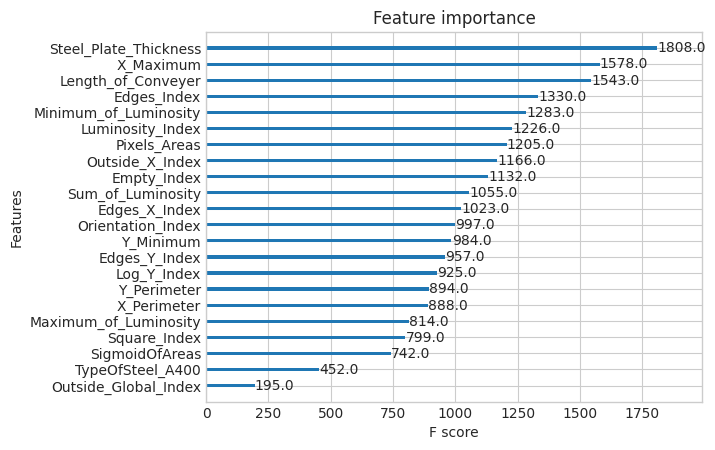

In [29]:
#Plot feature importance
from xgboost import plot_importance
plot_importance(xgbModel, importance_type='weight')
plt.show()

# <u><b>Playground Series S4E3 - Steel Plate Defect competition prediction</b></u>

In [30]:
#Import dataset
dataset_test = pd.read_csv("/kaggle/input/playground-series-s4e3/test.csv")
#Change index to id
dataset_test = dataset_test.set_index('id')
dataset_test.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,...,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
19220,1257,1271,419960,419973,370,26,28,39293,92,132,...,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
19221,1358,1372,117715,117724,289,36,32,29386,101,134,...,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
19222,158,168,232415,232440,80,10,11,8586,107,140,...,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
19223,559,592,544375,544389,140,19,15,15524,103,134,...,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170


In [31]:
#Make sure there are no NaNs and check each columns dtype
temp_df = pd.concat([dataset_test.isnull().sum(),dataset_test.dtypes],axis=1).rename(columns={0: "NaNs", 1: "dtype"})
temp_df

,NaNs,dtype
X_Minimum,0,int64
X_Maximum,0,int64
Y_Minimum,0,int64
Y_Maximum,0,int64
Pixels_Areas,0,int64
X_Perimeter,0,int64
Y_Perimeter,0,int64
Sum_of_Luminosity,0,int64
Minimum_of_Luminosity,0,int64
Maximum_of_Luminosity,0,int64


In [32]:
#Transformations to the features
#YeoJohnson transformations
dataset_test['Y_Minimum'] = yeojohnson(dataset_test['Y_Minimum'],lmbda=yj_lambda_val_Y_Minimum)
dataset_test['Minimum_of_Luminosity'] = yeojohnson(dataset_test['Minimum_of_Luminosity'],lmbda=yj_lambda_val_Minimum_of_Luminosity)
dataset_test['Orientation_Index'] = yeojohnson(dataset_test['Orientation_Index'],lmbda=yj_lambda_val_Orientation_Index)
dataset_test['Log_Y_Index'] = yeojohnson(dataset_test['Log_Y_Index'],lmbda=yj_lambda_val_Log_Y_Index)
#BoxCox transformations
dataset_test['Pixels_Areas'] = boxcox(dataset_test['Pixels_Areas'], lmbda=boxcox_lambda_val_Pixels_Areas)
dataset_test['X_Perimeter'] = boxcox(dataset_test['X_Perimeter'], lmbda=boxcox_lambda_val_X_Perimeter)
dataset_test['Y_Perimeter'] = boxcox(dataset_test['Y_Perimeter'],lmbda=boxcox_lambda_val_Y_Perimeter)
dataset_test['Sum_of_Luminosity'] = boxcox(dataset_test['Sum_of_Luminosity'],lmbda=boxcox_lambda_val_Sum_of_Luminosity)
#Inverse Log transformation on Edges_X_Index
dataset_test['Edges_X_Index'] = np.exp(dataset_test['Edges_X_Index'])

In [33]:
#drop features
dataset_test.drop(['X_Minimum','Y_Maximum','TypeOfSteel_A300','LogOfAreas','Log_X_Index'],axis=1,inplace=True)

In [34]:
#Standardise the features
dataset_test[numerical_features] = sc.fit_transform(dataset_test[numerical_features])
dataset_test.head()

,X_Maximum,Y_Minimum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A400,...,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
19219,0.558641,1.182064,0.659754,-0.200411,0.512558,0.585877,-0.654567,-0.118264,1.340571,1,...,0.651329,-0.953735,-0.435558,-0.346723,0.754329,0.858729,0.728377,1.200885,-0.734548,1.038671
19220,1.033953,-0.911396,0.340958,-0.071302,0.064180,0.323546,0.223410,0.231866,-0.726433,1,...,0.040899,-1.857894,-0.534199,-1.541870,0.754329,0.858729,0.219810,1.750518,-0.049069,1.018187
19221,1.235661,-1.672045,0.190699,0.242586,0.190615,0.143015,0.554929,0.371917,-0.685367,1,...,1.726007,-0.377164,-0.312256,-0.193713,-0.380500,-1.210424,-0.093376,-1.254983,0.814566,0.237976
19222,-1.168857,-1.296451,-0.748019,-1.264143,-0.956824,-0.777410,0.780008,0.792073,1.573280,0,...,-0.604068,0.947130,-0.554749,0.796793,0.754329,0.858729,-0.854817,0.114343,0.557511,-1.106457
19223,-0.322083,-0.722983,-0.303988,-0.414479,-0.589630,-0.300499,0.629604,0.371917,1.559591,0,...,-1.177551,-0.561480,-0.306091,1.031751,-1.364170,-1.210424,-0.560724,-1.340361,0.425166,-0.468130


In [35]:
#Prediction on submission set
y_pred_submission = xgbModel.predict_proba(dataset_test)

In [36]:
#Get predictions in expected submission file format
y_pred_submission_df = pd.DataFrame(y_pred_submission)
y_pred_submission_df.columns = y.columns.tolist()
y_pred_submission_df.index = dataset_test.index
y_pred_submission_df.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
19219,0.450480,0.002157,0.004959,0.000231,0.011462,0.198646,0.393260
19220,0.276881,0.012523,0.011080,0.000284,0.132973,0.148511,0.460372
19221,0.001763,0.040610,0.051014,0.000553,0.009001,0.279116,0.451973
19222,0.130262,0.004285,0.001016,0.002555,0.006146,0.356823,0.446867
19223,0.003285,0.004145,0.001227,0.003226,0.014434,0.594929,0.359940


In [37]:
#Create submission
y_pred_submission_df.to_csv("submission.csv")

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#4b4be2;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
Thank you for reading through my notebook on Steel Plate Defects. I hope you enjoyed it and found it interesting☺️👍🏻. I will reply to any comments you have on this notebook. Have a good day!🚀
</p>
</div>